# Imports

In [1]:
import sys
 
# setting path
sys.path.append('..')

In [2]:
from model_builder import ModelBuilder
import matplotlib.pyplot as plt

2022-12-01 11:34:50.668220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/model_utilities/model_utilities


# Model

Initialize the model builder

In [3]:
model_builder = ModelBuilder()

# Create Dataset

We want to predict the deforestation risk using predictors such as terrain information, proximity to roads/pasture/agriculture/urbanization, population density, etc. 
Create the dataset for the training from the csv files that contains all the samples 

In [4]:
# Response variable is the deforestation risk value
response_variable=['deforestation_risk_Acre']

# Predictors names that we want to use for the training
feature_names = ['brazil_roads',
                 'elevation',
                 'slope',
                 'brazil_protected_areas',
                 'population_density',
                 'brazil_surrounding_forest',
                 'brazil_pasture',
                 'brazil_agriculture',
                 'south_america_rivers',
                 'urban_distance']
# feature_names = ['brazil_roads',
#                  'brazil_protected_areas',
#                  'population_density',
#                  'brazil_surrounding_forest',
#                  'brazil_pasture',
#                  'urban_distance']

gcp_bucket = 'eartshot-science-team'
gcp_folder_name = 'deforestation_risk'
samples_folder_name = f'Brazil_Acre_100km2_grids_samples_csv_scale30_1000numPoints'
name_csv_samples_merged_file = '/Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_100km2_grids_samples_csv_scale30_1000numPoints/Brazil_Acre_100km2_grids_samples_csv_scale30_1000numPoints_val_test_set_5km_buffer.csv'


Create the dataset with train, test and val splits

In [5]:
model_builder.train_val_test_split(response_variable=response_variable, 
                             samples_csv_local=True,
                             feature_names=feature_names, 
                             gcp_bucket=gcp_bucket, 
                             gcp_folder_name=gcp_folder_name, 
                             samples_folder_name= samples_folder_name, 
                             name_csv_samples_merged_file = name_csv_samples_merged_file, 
                             use_test_val_buffered_sets = False,
                             test_size=0.20,
                             # name_test_buffer_column='test_set_5km_buffer', 
                             # name_val_buffer_column='val_set_5km_buffer', 
                             # name_test_no_buffer_column='test_set_no_buffer', 
                             # name_val_no_buffer_column='val_set_no_buffer'
                            )

Reading sample csv file: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_100km2_grids_samples_csv_scale30_1000numPoints/Brazil_Acre_100km2_grids_samples_csv_scale30_1000numPoints_val_test_set_5km_buffer.csv...
We have 297322 samples
Training samples: 237857
Test samples: 59465
Validation samples: 0


Let's take a look at our training predictors:

In [6]:
model_builder.X_train.head()

,brazil_roads,elevation,slope,brazil_protected_areas,population_density,brazil_surrounding_forest,brazil_pasture,brazil_agriculture,south_america_rivers,urban_distance
74058,23818.293582,173,0,177674.320284,0.423144,918,40,0,1292.089820,20517
106018,15513.510126,190,1,29363.389572,1.860605,961,0,0,1051.277662,16865
19902,10640.357294,223,8,110540.556156,2.102675,532,429,0,1018.560161,11899
175334,224774.298513,368,9,130510.381483,0.036595,961,0,0,858.104976,141130
188892,8515.704376,260,1,109.085874,6.680561,961,0,0,900.741474,25273


Now our training targets:

In [7]:
model_builder.y_train.head(2)

,deforestation_risk_Acre
74058,0
106018,0


In [8]:
nb_forest_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples} forest samples and {nb_deforested_samples} deforested samples in training set')

nb_forest_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples_test} forest samples and {nb_deforested_samples_test} deforested samples in test set')


There are 204451 forest samples and 33406 deforested samples in training set
There are 51199 forest samples and 8266 deforested samples in test set


In [9]:
model_builder.feature_names

['brazil_roads',
 'elevation',
 'slope',
 'brazil_protected_areas',
 'population_density',
 'brazil_surrounding_forest',
 'brazil_pasture',
 'brazil_agriculture',
 'south_america_rivers',
 'urban_distance']

In [10]:
model_builder.response_variable

['deforestation_risk_Acre']

# Training

In [11]:
model_builder.initialize_model(model_type='RandomForestClassifier', 
                               nb_trees=100, max_depth=4, random_state=42, 
                               criterion='gini',
                               min_samples_split=2, min_samples_leaf=1, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               max_features='sqrt', 
                               n_cores=-1, 
                               oob_score=True, bootstrap=True,
                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [12]:
model_builder.model

RandomForestClassifier(max_depth=4, n_jobs=-1, oob_score=True, random_state=42,
                       verbose=1)

In [13]:
model_builder.train()

/Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/model_utilities/model_utilities/tests/../model_builder.py:305: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X_train, self.y_train.values)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


# Evaluation


Evaluation...



Mean Absolute Error (MAE): 0.12400571764903724
Mean Squared Error (MSE): 0.12400571764903724
Root Mean Squared Error (RMSE): 0.3521444556556829
R2: -0.03611432213138421
OOB prediction of accuracy is: 87.50173423527582%



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


R2 with predictions probabilities: 0.2226803195601318
ROC-AUC score of the model:   0.8406343927305056
Accuracy of the model: 0.8759942823509628

Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     51199
           1       0.69      0.19      0.30      8266

    accuracy                           0.88     59465
   macro avg       0.79      0.59      0.62     59465
weighted avg       0.86      0.88      0.84     59465


Confusion matrix: 
[[50487   712]
 [ 6662  1604]]



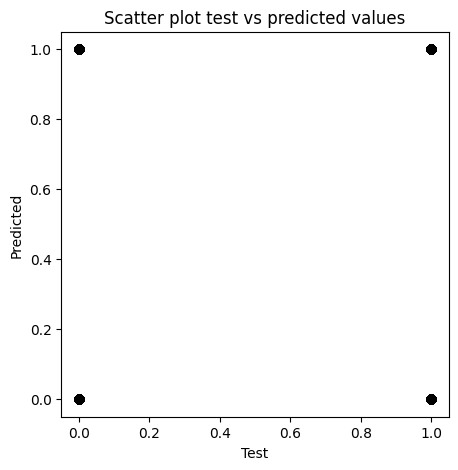

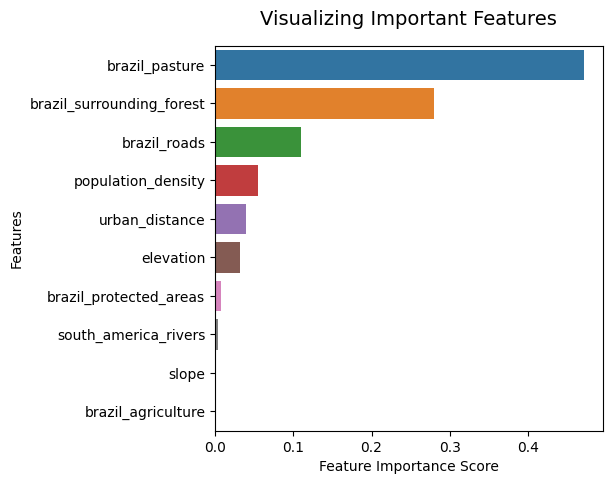

In [14]:
# On test set
y_pred_test, mae_test, mse_test, rmse_test, oob_score_test, r2_test, feature_imp_test = model_builder.evaluate(X_test=model_builder.X_test,
                                                                    y_test=model_builder.y_test,
                                                                    save_figures=False, saving_base_output_name='testing_test_set',
                                                                    feature_importance=True)

# Inference on tiles

In [27]:
model_builder.inference(mask_band='elevation', 
                        tiles_folder_name='Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30', 
                        tiles_in_GCP=False,   # Running locally
                        RF_output_folder_temp='TEST_RF_outputs_temp_Acre_classifier_prob',
                        path_to_tiles_local='/Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30'
                       )

There are 31 inference tiles

Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_8.tif
Image opened
tile shape: (3291, 3334, 10)
Reshaped from (3291, 3334, 10) to (10972194, 10)
(10972194, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3291, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34 120
 121 122 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255]
(3291, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_17_01_0.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   22.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3291, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  99 100 101 102 103 104 105 106 108 112
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
(3291, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_17_44_1.tif




Starting image: /Users/margauxmforstyhe/

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   21.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3281, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  43 124 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255]
(3281, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_18_21_2.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acr

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (834, 670)
[  0 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216]
(834, 670)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_18_23_3.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_24.tif
Image opened
tile shape: (827, 3331, 10)
Reshaped from (827, 3331, 10) to (2754737, 10)
(2754737, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (827, 3331)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 206 246 248 250 251 252 253 254 255]
(827, 3331)
Image saved to:

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (118, 37)
[  0 156 157 158 159 160 161 162 163 164 166 167 172 174 178 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 203]
(118, 37)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_18_33_5.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_18.tif
Image opened
tile shape: (2354, 3335, 10)
Reshaped from (2354, 3335, 10) to (7850590, 10)
(7850590, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   12.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2354, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  28 148 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255]
(2354, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_18_54_6.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_26.tif
Image opened
tile shape: (1713, 3334, 10)
Reshaped from (1713, 3334, 10) to (5711142, 10)
(5711142, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   14.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1713, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
(1713, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_19_13_7.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    7.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1520, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 137 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255]
(1520, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_19_26_8.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inf

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   20.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3281, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 212 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255]
(3281, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_19_59_9.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_s

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3281, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255]
(3281, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_20_37_10.tif




Starting image: /Users/

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   12.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   29.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3281, 3335)
[  0 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249]
(3281, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_21_20_11.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_21.tif
Image opened
tile shape: (3281, 3335, 10)
Reshaped from (3281, 3335

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   29.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3281, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 109 111 112 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
(3281, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_22_05_12.tif




Starting image: /Users/margauxmforstyhe

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   13.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3291, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
(3291, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_22_25_13.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100k

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   11.6s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3289, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 191 192 193 194 196 199 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 23

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (557, 445)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80]
(557, 445)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_22_43_15.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_12.tif
Image opened
tile shape: (3291, 3334, 10)
Reshaped from (3291, 3334, 10) to (10972194, 10)
(10972194, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   20.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3291, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 202 203 204 205 206 213 215 216 217 218 219 220 221 222 223
 224 225 226 227 22

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    9.2s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1502, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  56
  57 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]
(1502, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_23_33_17.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_17.tif
Image opened
tile shape: (3305, 3334, 10)
Reshaped 

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   31.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3305, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 22

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (729, 1955)
[  0 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244]
(729, 1955)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_24_20_19.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_29.tif
Image opened
tile shape: (1434, 831, 10)
Reshaped from (1434, 831, 10) to (1191654, 10)
(1191654, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1434, 831)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 251 253 254 255]
(1434, 831)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_24_22_20.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   10.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1798, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255]
(1798, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_24_39_21.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_D

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1114, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  58  61  62  63  65 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255]
(1114, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_24_49_22.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_infere

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   27.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3298, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 117 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 25

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    9.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2120, 2475)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31 133 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255]
(2120, 2475)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_25_42_24.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_2.tif

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   21.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3298, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255]
(3298, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_26_18_25.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_3.tif
Image opened
tile shape: (3298, 3334, 10)
Reshaped from (3298, 3

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3298, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]
(3298, 3334)
Image saved t

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1116, 2966)
[  0 112 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234]
(1116, 2966)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_27_00_27.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_6.tif
Image opened
tile shape: (2624, 3334, 10)
Reshaped from (2624, 3334, 10) to (8748416, 10)
(8748416, 10)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2624, 3334)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255]
(2624, 3334)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_27_29_28.tif




Starting image: /Users/margauxmforstyhe/Desktop/deforestation_risk/Brazil_Acre_Deforestation_Risk_inference_100km2_grid_scale30/inference_tiles_scale30_4.tif
Image opened
tile shape: (3102, 2180, 10)
Reshaped from (310

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3102, 2180)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 22

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   14.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3298, 3335)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85 176 177 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
(3298, 3335)
Image saved to: TEST_RF_outputs_temp_Acre_classifier_prob/RF_output_2022-11-23-16_28_02_30.tif



Done: 31 tiles predicted
There are 31 prediction rasters to be merged.
ROOT_DIR: /Users/margauxmforstyhe/Desktop/